# GCN

Implementation of Semi-Supervised Classification with Graph Convolutional Networks (https://arxiv.org/abs/1609.02907)
Thomas N. Kipf, Max Welling.

## Importing Libraries

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import community.community_louvain as community_louvain  # Correct import
import igraph as ig
import leidenalg
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx


## 1. Zachary Karate Club Data Set

### Loading data

In [6]:
# Load Zachary's Karate Club Graph
G_karate = nx.karate_club_graph()

In [7]:
# Ensure the graph is undirected
G_karate = G_karate.to_undirected()

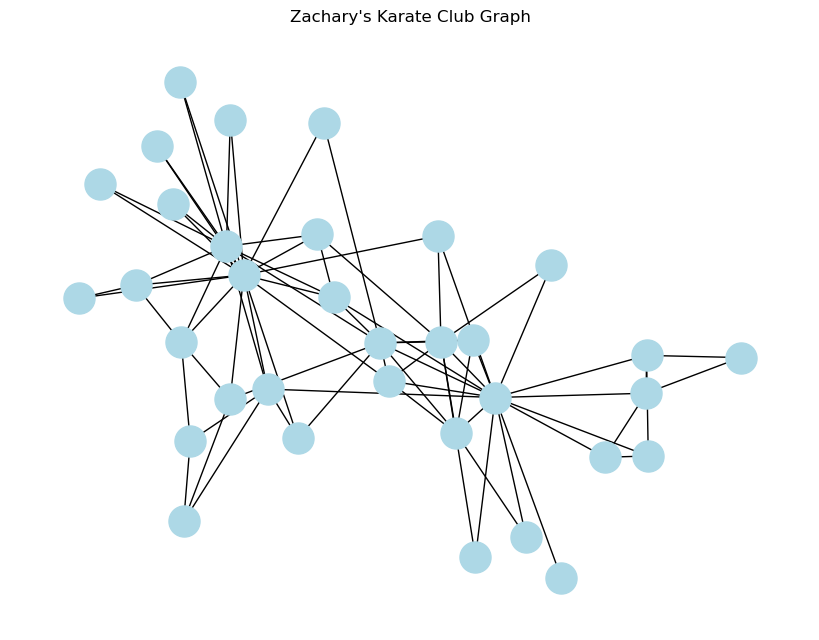

In [8]:
# Visualization
plt.figure(figsize=(8, 6))
nx.draw(G_karate, with_labels=False, node_color='lightblue', node_size=500, font_size=10)
plt.title("Zachary's Karate Club Graph")
plt.show()


In [9]:
# Convert to PyTorch Geometric format for GCN
data_karate = from_networkx(G_karate)

# Initialize node features (e.g., identity matrix or random features)
data_karate.x = torch.eye(data_karate.num_nodes)  # Identity matrix as node features

# Add synthetic labels (for demonstration purposes)
data_karate.y = torch.tensor([0 if i < len(G_karate) / 2 else 1 for i in range(len(G_karate))], dtype=torch.long)


In [10]:
# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data_karate.num_node_features, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [12]:
# Train GCN
model = GCN()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data_karate)
    loss = F.nll_loss(out, data_karate.y)  # Using synthetic labels
    loss.backward()
    optimizer.step()
    return loss.item()

# Training loop
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

Epoch 0, Loss: 0.7043185234069824
Epoch 10, Loss: 0.622562050819397
Epoch 20, Loss: 0.5046252608299255
Epoch 30, Loss: 0.4481486976146698
Epoch 40, Loss: 0.34926745295524597
Epoch 50, Loss: 0.3308245837688446
Epoch 60, Loss: 0.236320361495018
Epoch 70, Loss: 0.20248404145240784
Epoch 80, Loss: 0.1864437758922577
Epoch 90, Loss: 0.1910001039505005
Epoch 100, Loss: 0.12751543521881104
Epoch 110, Loss: 0.11942297220230103
Epoch 120, Loss: 0.11754056066274643
Epoch 130, Loss: 0.12145217508077621
Epoch 140, Loss: 0.12355438619852066
Epoch 150, Loss: 0.09584744274616241
Epoch 160, Loss: 0.07268299907445908
Epoch 170, Loss: 0.058534760028123856
Epoch 180, Loss: 0.07456857711076736
Epoch 190, Loss: 0.04802056774497032


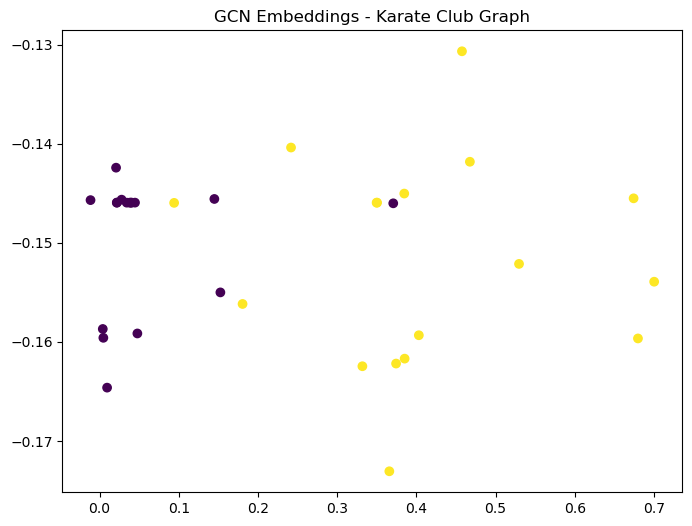

In [13]:
# Get embeddings
model.eval()
with torch.no_grad():
    embeddings = model.conv1(data_karate.x, data_karate.edge_index).numpy()

# Visualize embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=data_karate.y)
plt.title("GCN Embeddings - Karate Club Graph")
plt.show()

In [14]:
# Calculate modularity for GCN-based clustering (using KMeans)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters_gcn = kmeans.fit_predict(embeddings)

# Convert clusters into a format suitable for modularity calculation
clusters_gcn_dict = {i: clusters_gcn[i] for i in range(len(clusters_gcn))}
gcn_modularity = community_louvain.modularity(clusters_gcn_dict, G_karate)
print(f"Modularity for GCN-based clustering: {gcn_modularity}")

# Louvain clustering
louvain_communities = community_louvain.best_partition(G_karate)
modularity_louvain = community_louvain.modularity(louvain_communities, G_karate)
print(f"Modularity for Louvain clustering: {modularity_louvain}")

# Leiden clustering
ig_G_karate = ig.Graph.from_networkx(G_karate)
leiden_communities = leidenalg.find_partition(ig_G_karate, leidenalg.ModularityVertexPartition)
modularity_leiden = leiden_communities.modularity
print(f"Modularity for Leiden clustering: {modularity_leiden}")

# Label Propagation clustering
label_propagation = nx.algorithms.community.label_propagation_communities(G_karate)
modularity_label_propagation = nx.algorithms.community.modularity(G_karate, label_propagation)
print(f"Modularity for Label Propagation clustering: {modularity_label_propagation}")


Modularity for GCN-based clustering: 0.22352467157661962
Modularity for Louvain clustering: 0.44490358126721763
Modularity for Leiden clustering: 0.41978961209730437
Modularity for Label Propagation clustering: 0.30948632896684847


# 2. Enron mail Data set

In [16]:
# Load Email Enron-only Dataset
email_enron_path = 'email-enron-only.mtx'
G_email_enron = nx.read_edgelist(email_enron_path, create_using=nx.Graph())

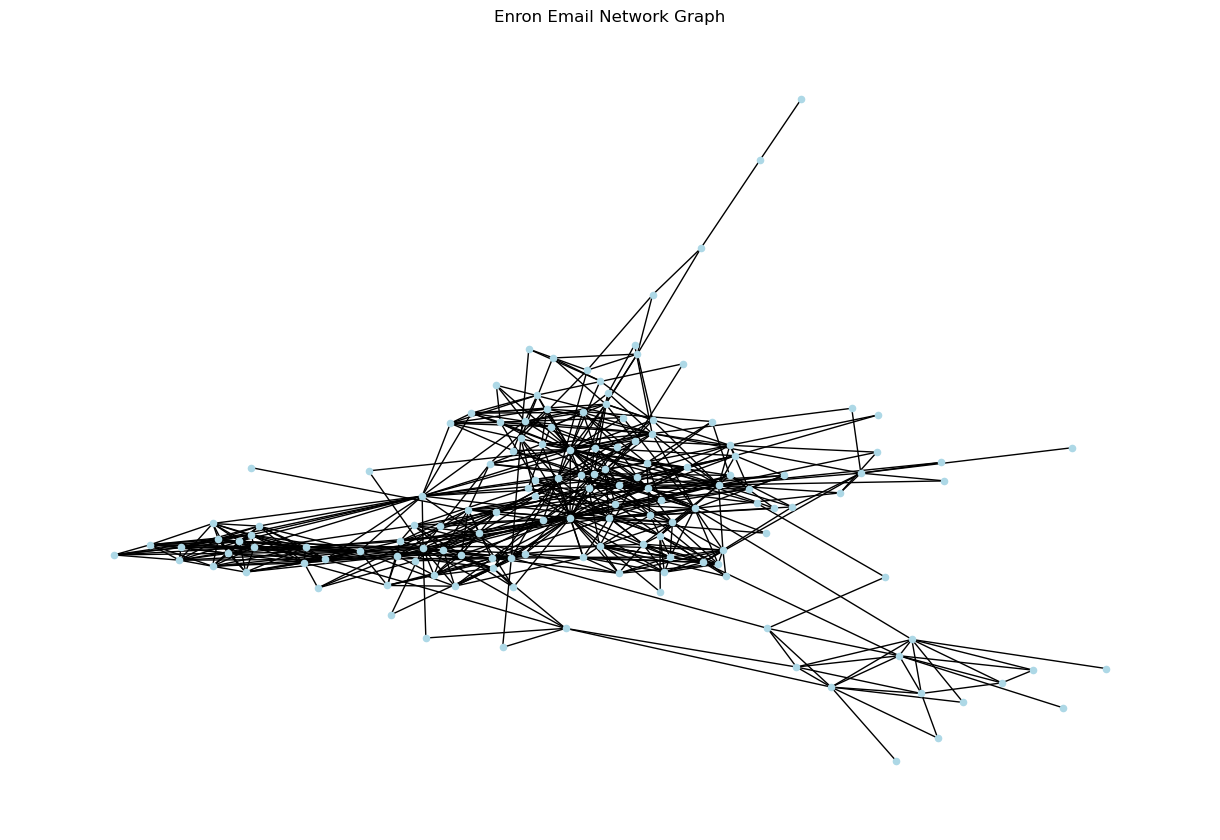

In [17]:
# Ensure the graph is undirected
G_email_enron = G_email_enron.to_undirected()

# Visualization
plt.figure(figsize=(12, 8))
nx.draw(G_email_enron, with_labels=False, node_color='lightblue', node_size=20)
plt.title("Enron Email Network Graph")
plt.show()

In [18]:
# Convert to PyTorch Geometric format for GCN
data_email_enron = from_networkx(G_email_enron)

# Initialize node features (e.g., identity matrix or random features)
data_email_enron.x = torch.eye(data_email_enron.num_nodes)

# Add synthetic labels (for demonstration purposes)
data_email_enron.y = torch.tensor([0 if i < len(G_email_enron) / 2 else 1 for i in range(len(G_email_enron))], dtype=torch.long)


In [19]:
# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data_email_enron.num_node_features, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [20]:
# Train GCN
model = GCN()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data_email_enron)
    loss = F.nll_loss(out, data_email_enron.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Training loop
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')


Epoch 0, Loss: 0.6918579936027527
Epoch 10, Loss: 0.613569974899292
Epoch 20, Loss: 0.49505850672721863
Epoch 30, Loss: 0.3804183304309845
Epoch 40, Loss: 0.30690473318099976
Epoch 50, Loss: 0.2840941846370697
Epoch 60, Loss: 0.2570092976093292
Epoch 70, Loss: 0.22174395620822906
Epoch 80, Loss: 0.22890552878379822
Epoch 90, Loss: 0.19662468135356903
Epoch 100, Loss: 0.19253307580947876
Epoch 110, Loss: 0.185738667845726
Epoch 120, Loss: 0.17833568155765533
Epoch 130, Loss: 0.19911612570285797
Epoch 140, Loss: 0.17336972057819366
Epoch 150, Loss: 0.17994123697280884
Epoch 160, Loss: 0.1760631501674652
Epoch 170, Loss: 0.16904112696647644
Epoch 180, Loss: 0.15507513284683228
Epoch 190, Loss: 0.15073783695697784


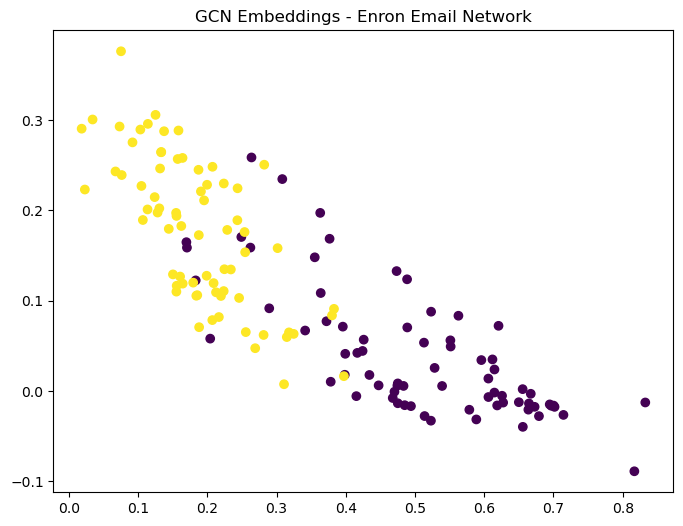

In [21]:
# Get embeddings
model.eval()
with torch.no_grad():
    embeddings = model.conv1(data_email_enron.x, data_email_enron.edge_index).numpy()

# Visualize embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=data_email_enron.y)
plt.title("GCN Embeddings - Enron Email Network")
plt.show()

In [22]:
# Calculate modularity for GCN-based clustering (using KMeans)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters_gcn = kmeans.fit_predict(embeddings)

# Map clusters back to the original node IDs
clusters_gcn_dict = {list(G_email_enron.nodes())[i]: clusters_gcn[i] for i in range(len(clusters_gcn))}
gcn_modularity = community_louvain.modularity(clusters_gcn_dict, G_email_enron)
print(f"Modularity for GCN-based clustering: {gcn_modularity}")

# Louvain clustering
louvain_communities = community_louvain.best_partition(G_email_enron)
modularity_louvain = community_louvain.modularity(louvain_communities, G_email_enron)
print(f"Modularity for Louvain clustering: {modularity_louvain}")

# Leiden clustering
ig_G_email_enron = ig.Graph.from_networkx(G_email_enron)
leiden_communities = leidenalg.find_partition(ig_G_email_enron, leidenalg.ModularityVertexPartition)
modularity_leiden = leiden_communities.modularity
print(f"Modularity for Leiden clustering: {modularity_leiden}")

# Label Propagation clustering
label_propagation = nx.algorithms.community.label_propagation_communities(G_email_enron)
modularity_label_propagation = nx.algorithms.community.modularity(G_email_enron, label_propagation)
print(f"Modularity for Label Propagation clustering: {modularity_label_propagation}")


Modularity for GCN-based clustering: 0.2291957055515048
Modularity for Louvain clustering: 0.5676901236444585
Modularity for Leiden clustering: 0.566837314398048
Modularity for Label Propagation clustering: 0.4859840413883013


# 3. University mail Data set

In [23]:
# Load Email University Network Dataset
email_univ_path = 'email-univ.edges'
G_email_univ = nx.read_edgelist(email_univ_path, create_using=nx.Graph())


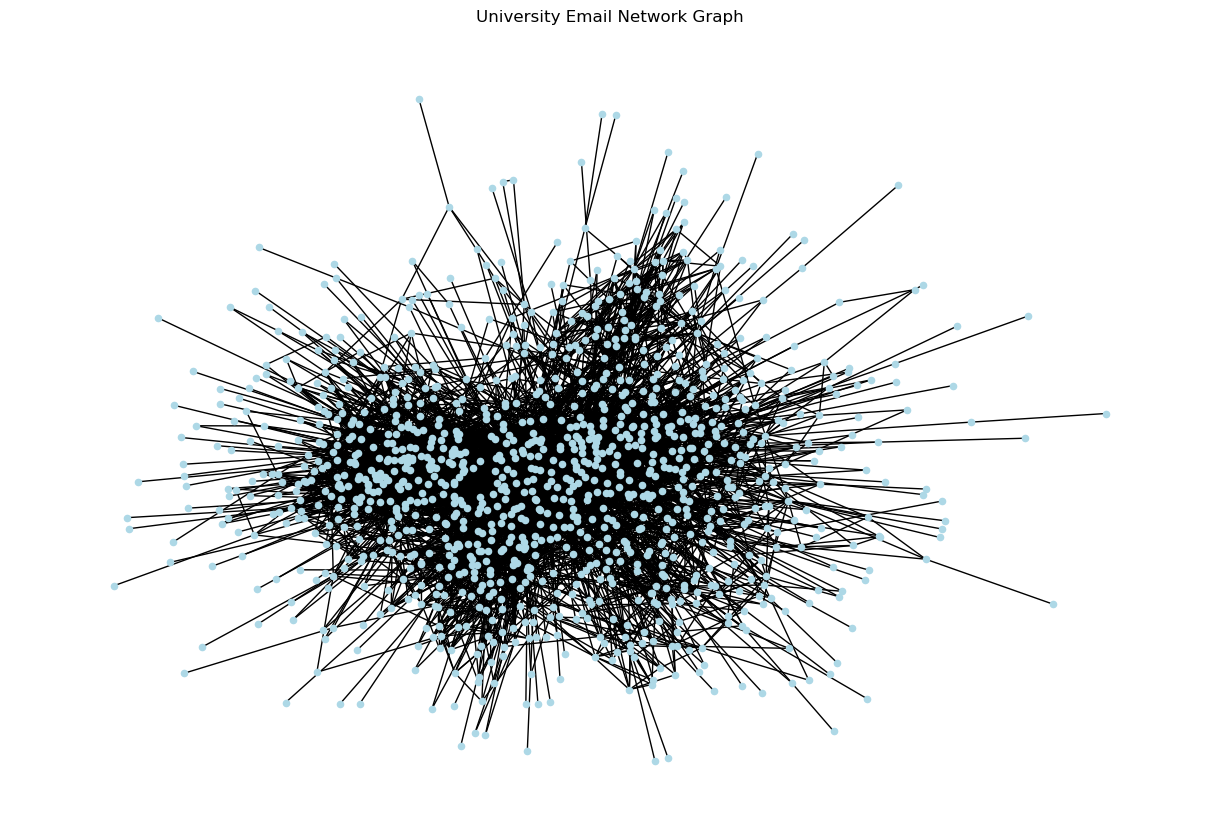

In [24]:
# Ensure the graph is undirected
G_email_univ = G_email_univ.to_undirected()

# Visualization
plt.figure(figsize=(12, 8))
nx.draw(G_email_univ, with_labels=False, node_color='lightblue', node_size=20)
plt.title("University Email Network Graph")
plt.show()

In [25]:
# Convert to PyTorch Geometric format for GCN
data_email_univ = from_networkx(G_email_univ)

# Initialize node features (e.g., identity matrix or random features)
data_email_univ.x = torch.eye(data_email_univ.num_nodes)

# Add synthetic labels (for demonstration purposes)
data_email_univ.y = torch.tensor([0 if i < len(G_email_univ) / 2 else 1 for i in range(len(G_email_univ))], dtype=torch.long)


In [26]:
# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data_email_univ.num_node_features, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [27]:
# Train GCN
model = GCN()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data_email_univ)
    loss = F.nll_loss(out, data_email_univ.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Training loop
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')


Epoch 0, Loss: 0.6934741139411926
Epoch 10, Loss: 0.6447657942771912
Epoch 20, Loss: 0.5682686567306519
Epoch 30, Loss: 0.502312958240509
Epoch 40, Loss: 0.45669886469841003
Epoch 50, Loss: 0.42716118693351746
Epoch 60, Loss: 0.4099788963794708
Epoch 70, Loss: 0.3943198621273041
Epoch 80, Loss: 0.3802803158760071
Epoch 90, Loss: 0.37460511922836304
Epoch 100, Loss: 0.37024784088134766
Epoch 110, Loss: 0.3591936230659485
Epoch 120, Loss: 0.3507504165172577
Epoch 130, Loss: 0.3572045564651489
Epoch 140, Loss: 0.3356722891330719
Epoch 150, Loss: 0.34141167998313904
Epoch 160, Loss: 0.34773269295692444
Epoch 170, Loss: 0.3323955535888672
Epoch 180, Loss: 0.32766953110694885
Epoch 190, Loss: 0.3163509666919708


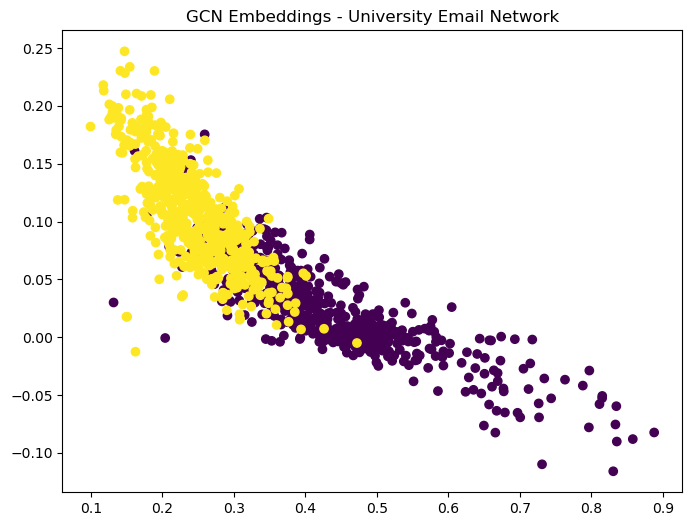

In [28]:
# Get embeddings
model.eval()
with torch.no_grad():
    embeddings = model.conv1(data_email_univ.x, data_email_univ.edge_index).numpy()

# Visualize embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=data_email_univ.y)
plt.title("GCN Embeddings - University Email Network")
plt.show()

In [29]:
# Calculate modularity for GCN-based clustering (using KMeans)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters_gcn = kmeans.fit_predict(embeddings)

# Map clusters back to the original node IDs
clusters_gcn_dict = {list(G_email_univ.nodes())[i]: clusters_gcn[i] for i in range(len(clusters_gcn))}
gcn_modularity = community_louvain.modularity(clusters_gcn_dict, G_email_univ)
print(f"Modularity for GCN-based clustering: {gcn_modularity}")

# Louvain clustering
louvain_communities = community_louvain.best_partition(G_email_univ)
modularity_louvain = community_louvain.modularity(louvain_communities, G_email_univ)
print(f"Modularity for Louvain clustering: {modularity_louvain}")

# Leiden clustering
ig_G_email_univ = ig.Graph.from_networkx(G_email_univ)
leiden_communities = leidenalg.find_partition(ig_G_email_univ, leidenalg.ModularityVertexPartition)
modularity_leiden = leiden_communities.modularity
print(f"Modularity for Leiden clustering: {modularity_leiden}")

# Label Propagation clustering
label_propagation = nx.algorithms.community.label_propagation_communities(G_email_univ)
modularity_label_propagation = nx.algorithms.community.modularity(G_email_univ, label_propagation)
print(f"Modularity for Label Propagation clustering: {modularity_label_propagation}")


Modularity for GCN-based clustering: 0.19723033388200825
Modularity for Louvain clustering: 0.5669143528874395
Modularity for Leiden clustering: 0.5769957636286741
Modularity for Label Propagation clustering: 0.4633824482091431


# 4. Cora Data set

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import networkx as nx
import community.community_louvain as community_louvain
import leidenalg
import igraph as ig
import matplotlib.pyplot as plt

from spektral.data.loaders import SingleLoader
from spektral.datasets.citation import Citation
from spektral.layers import GCNConv
from spektral.models.gcn import GCN
from spektral.transforms import LayerPreprocess
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [17]:
# Configuration
learning_rate = 1e-2
seed = 0
epochs = 200
patience = 10
data = "cora"  # Using the Cora dataset

tf.random.set_seed(seed=seed)  # Ensure reproducibility

# Load dataset and preprocess for GCN
dataset = Citation(data, normalize_x=True, transforms=[LayerPreprocess(GCNConv)])


Pre-processing node features


/Users/shreeshangaavin/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [19]:
# Convert binary masks to sample weights for loss computation
def mask_to_weights(mask):
    return mask.astype(np.float32) / np.count_nonzero(mask)

weights_tr, weights_va, weights_te = (
    mask_to_weights(mask)
    for mask in (dataset.mask_tr, dataset.mask_va, dataset.mask_te)
)

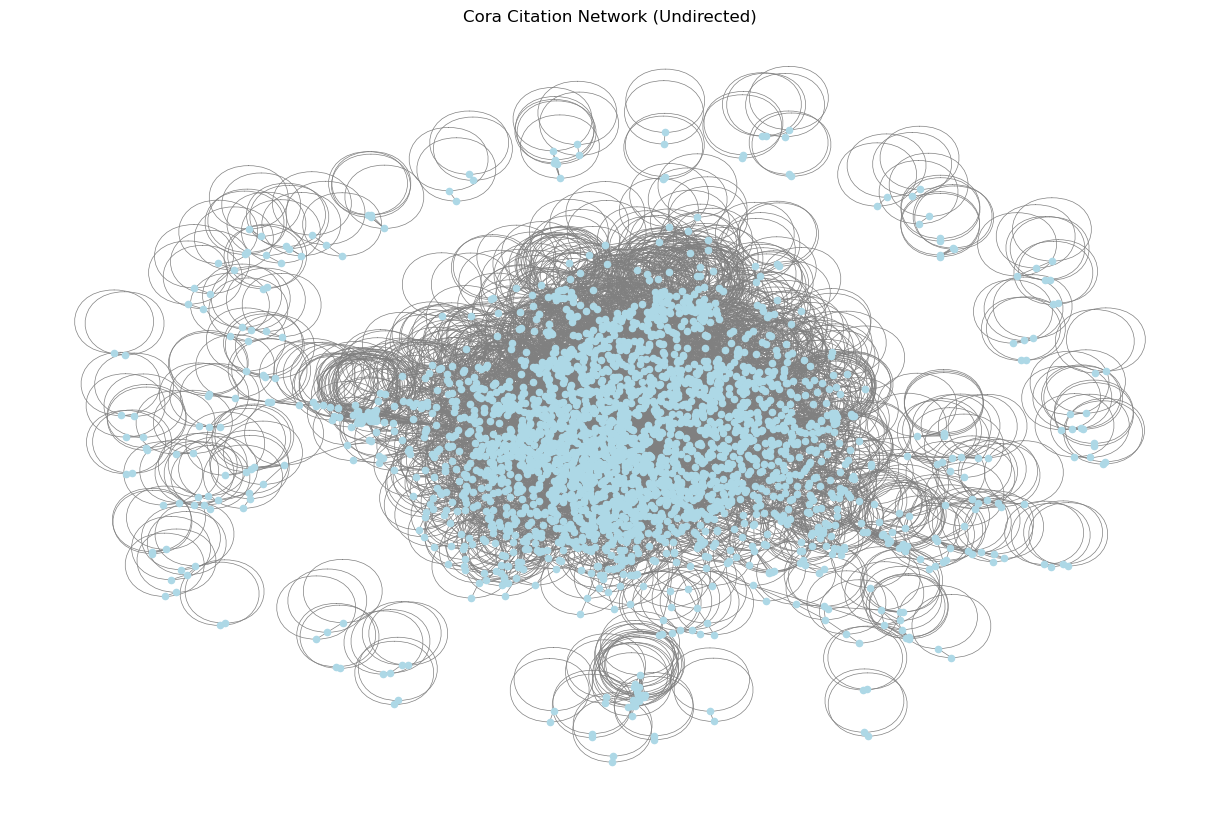

In [21]:
# Ensure the graph is undirected
adj_matrix = dataset[0].a.todense()
adj_matrix = np.maximum(adj_matrix, adj_matrix.T)  # Ensure symmetry
G = nx.from_numpy_array(adj_matrix)

# Visualization of the Cora dataset graph structure
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=False, node_color='lightblue', node_size=20, edge_color='gray', width=0.5)
plt.title("Cora Citation Network (Undirected)")
plt.show()

In [23]:
# GCN Model
model = GCN(n_labels=dataset.n_labels)
model.compile(
    optimizer=Adam(learning_rate),
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)

# Train the GCN model
loader_tr = SingleLoader(dataset, sample_weights=weights_tr)
loader_va = SingleLoader(dataset, sample_weights=weights_va)
model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)],
)


Epoch 1/200
1/1 [==============================] - 0s 171ms/step - loss: 1.9539 - acc: 0.1286 - val_loss: 1.9491 - val_acc: 0.4040
Epoch 2/200
1/1 [==============================] - 0s 12ms/step - loss: 1.9469 - acc: 0.3357 - val_loss: 1.9447 - val_acc: 0.5140
Epoch 3/200
1/1 [==============================] - 0s 12ms/step - loss: 1.9413 - acc: 0.5714 - val_loss: 1.9394 - val_acc: 0.5800
Epoch 4/200
1/1 [==============================] - 0s 12ms/step - loss: 1.9346 - acc: 0.5643 - val_loss: 1.9338 - val_acc: 0.6320
Epoch 5/200
1/1 [==============================] - 0s 13ms/step - loss: 1.9244 - acc: 0.7143 - val_loss: 1.9281 - val_acc: 0.6480
Epoch 6/200
1/1 [==============================] - 0s 12ms/step - loss: 1.9163 - acc: 0.6643 - val_loss: 1.9229 - val_acc: 0.6360
Epoch 7/200
1/1 [==============================] - 0s 13ms/step - loss: 1.9080 - acc: 0.7143 - val_loss: 1.9177 - val_acc: 0.6340
Epoch 8/200
1/1 [==============================] - 0s 12ms/step - loss: 1.9000 - acc: 0.7

In [25]:
# Evaluate the GCN model
print("Evaluating model.")
loader_te = SingleLoader(dataset, sample_weights=weights_te)
eval_results = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done.\nTest loss: {}\nTest accuracy: {}".format(*eval_results))


Evaluating model.
1/1 [==============================] - 0s 12ms/step - loss: 1.0313 - acc: 0.8130
Done.
Test loss: 1.031296730041504
Test accuracy: 0.8130002021789551


/Users/shreeshangaavin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


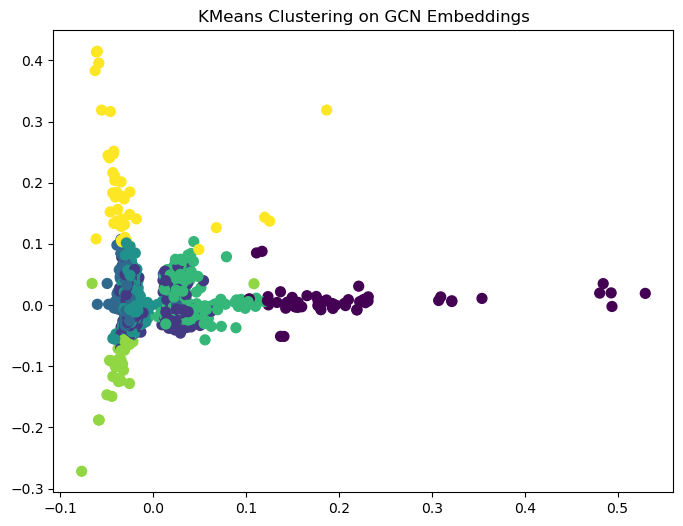

In [27]:
# Get GCN embeddings (using the first GCN layer)
embeddings = model.layers[0](dataset[0].x).numpy()

# KMeans clustering on GCN embeddings
kmeans = KMeans(n_clusters=dataset.n_labels, random_state=seed)
kmeans_clusters = kmeans.fit_predict(embeddings)

# Visualize KMeans clustering
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(embeddings)
plt.figure(figsize=(8, 6))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=kmeans_clusters, cmap='viridis', s=50)
plt.title("KMeans Clustering on GCN Embeddings")
plt.show()


In [29]:
# Modularity for GCN clustering
gcn_communities = {i: kmeans_clusters[i] for i in range(len(kmeans_clusters))}
modularity_gcn = community_louvain.modularity(gcn_communities, G)
print(f"Modularity for GCN clustering: {modularity_gcn}")

# Louvain method
louvain_communities = community_louvain.best_partition(G)
modularity_louvain = community_louvain.modularity(louvain_communities, G)
print(f"Modularity for Louvain clustering: {modularity_louvain}")

# Leiden method (requires converting to igraph)
ig_G = ig.Graph.from_networkx(G)
leiden_communities = leidenalg.find_partition(ig_G, leidenalg.ModularityVertexPartition)
modularity_leiden = leiden_communities.modularity
print(f"Modularity for Leiden clustering: {modularity_leiden}")

# Label Propagation
label_propagation = nx.algorithms.community.label_propagation_communities(G)
label_propagation_communities = {frozenset(x) for x in label_propagation}
modularity_label_propagation = nx.algorithms.community.quality.modularity(G, label_propagation_communities)
print(f"Modularity for Label Propagation clustering: {modularity_label_propagation}")


Modularity for GCN clustering: 0.40912649326291495
Modularity for Louvain clustering: 0.9171711692525462
Modularity for Leiden clustering: 0.8674896822005475
Modularity for Label Propagation clustering: 0.4582929951296467
